In [1]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes = True)

import warnings
warnings.filterwarnings('ignore')

/Users/gregoryklose/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df_ems = pd.read_excel('Data/Deidentified Hackathon Data 2017-12-04.xlsx')

In [3]:
df_ems.columns

Index(['incident_ID', 'incident_date', 'priority', 'zone', 'time_phone_pickup',
       'time_unit_arrived', 'time_incident_closed', 'disposition',
       'council_district', 'census_state_code', 'census_county_code',
       'census_tract', 'census_block', 'census_geoID', 'census_block_name'],
      dtype='object')

## As seen below an overwhelming majority of incidents are documented in City of Austin, therefore, I will focus on Austin (and make a histogram!)

In [ ]:
pd.value_counts(df_ems['zone'].values, sort=True)

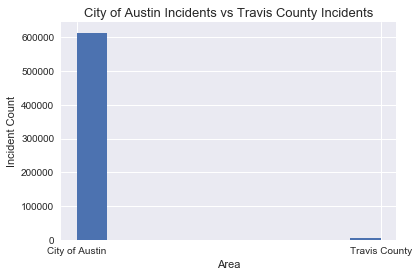

In [4]:
plt.hist(df_ems['zone'].values)
plt.title('City of Austin Incidents vs Travis County Incidents',fontsize=13)
plt.xlabel('Area')
plt.ylabel('Incident Count')
plt.show()

## Are EMS calls increasing Year-to-Year?

In [5]:
df_ems['Year'] = pd.DatetimeIndex(df_ems['time_phone_pickup']).year

In [ ]:
# Yes they are
pd.value_counts(df_ems['Year'].values, sort=False)

In [6]:
#remove zones that are not City of Austin
df2 = df_ems[df_ems['zone'] == 'City of Austin']
df2.shape


(613926, 16)

In [ ]:
df2['zone'].nunique()


In [ ]:
#df_ems.head()
#fema data for ambulance locations
#ark GIS

In [ ]:
#df_ems_loc = pd.read_csv('Data/Emergency_Medical_Service_EMS_Stations.csv',encoding='latin')

In [ ]:
#df_ems_loc.shape

## EDA

In [ ]:
#df2[df2['Year'] ==2017].count()

## Time_phone_pickup data prior to FY2016 was documented differently. I don't think I will be using the response call time for my analysis so that shouldn't be an issue

In [ ]:
df_ems.head()

## Create columns for day-of-week (both numeric and string) and month-of-year

In [7]:
df2['Month'] = pd.DatetimeIndex(df2['time_phone_pickup']).month
df2['Day'] = pd.DatetimeIndex(df2['time_phone_pickup']).day
df2['Day_of_week (int)'] = pd.DatetimeIndex(df2['time_phone_pickup']).weekday
df2['Day_of_week (name)'] = pd.DatetimeIndex(df2['time_phone_pickup']).weekday_name


In [8]:
df2['Day_of_week (name)'].unique()

array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'], dtype=object)

In [ ]:
df2.head()

## Because all zones and states are the same, I will drop both columns to reduce noise

In [9]:
df2 = df2.drop('zone',axis=1)
df2 = df2.drop('census_state_code',axis=1)

In [ ]:
#roughly 48k rows have null values for 'time_unit_arrived' column... I'm not exactly sure what to do with that
df2.isnull().sum()

## Find out on what day of the week most incidents occur

In [ ]:
#This distribution is surprisingly uniform
pd.value_counts(df2['Day_of_week (name)'].values, sort=True)

## Break of time of day (hours) into ranges to see if a specific time-range has more representation

In [10]:
df2['Hour'] = pd.DatetimeIndex(df2['time_phone_pickup']).hour

In [11]:
df2['Hour'].nunique()

24

In [ ]:
df2.head()

In [12]:

df2['Hour (10-23)'] = df2['Hour'].between(10,23).astype(int)
df2['Hour (0-9)'] = df2['Hour'].between(0,9).astype(int)

In [13]:
df2['Hour (0-9)'].unique()

array([0, 1])

## EDA to see where incidents occur most based on columns

In [ ]:
#This is interesting, it seems hours 10-20 have the highest amount of incidents. 
#I will do this with the use of dummy variables
pd.value_counts(df2['Hour'].values, sort=True)

In [ ]:
pd.value_counts(df2['Hour (0-9)'].values, sort=True)

In [ ]:
# Quick check to see if the values match up (they do)
# Roughly 2/3 of the incidents occur between the hours of 10-23
pd.value_counts(df2['Hour (10-23)'].values, sort=True)

In [ ]:
pd.value_counts(df2['census_tract'].values, sort=True)

In [ ]:
pd.value_counts(df2['council_district'].values, sort=True)

In [ ]:
# These are the 5 top blocks where incidents occur
pd.value_counts(df2['census_block_name'].values, sort=True).head()                                                 

In [ ]:
#Finaly some unbalnaced data! almost all incidents are occuring in county code 453
#I may focus only on county 453 because the data is so unbalanced 
pd.value_counts(df2['census_county_code'].values, sort=True)

In [ ]:
# It seems there's one geoID that has significanlty more incidents than the others
# I need to do some research to figure out exactly what a geoID signifies
pd.value_counts(df2['census_geoID'].values, sort=True)

## In order to use the geoID information I need to convert it to latitude and longitude columns. To effictively do that, I need to strip each value in the geoID column to only its first 11 characters.

In [14]:
df3 = df2

In [15]:
df3['FIPS_geoID'] = df3['census_geoID'].astype(str).str[0:11].astype(int)
#df3['FIPS_geoID'] = df3.apply(lambda x: x['census_geoID'][:x[12]], axis=1)    

## Re-arrange columns

In [ ]:
df3.columns

In [16]:
df3 = df3[['incident_date', 'priority', 'time_phone_pickup',
       'disposition','council_district', 'census_county_code', 'census_tract',
       'census_block', 'census_geoID','FIPS_geoID', 'census_block_name', 'Year', 'Month',
       'Day', 'Day_of_week (int)', 'Day_of_week (name)', 'Hour',
       'Hour (10-23)', 'Hour (0-9)','incident_ID','time_incident_closed','time_unit_arrived']]

In [17]:
df3['FIPS_geoID'].nunique()

215

In [ ]:
df3.head()

In [18]:
df_geo2_lat_long = pd.read_csv('data/geo_merge_data.csv')

In [19]:
df_geo2_lat_long.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Location', 'Arthritis', 'Cancer_x',
       'Diabetes_x', 'Cholesterol_x', 'Obese_x', 'HBP_x', 'Routine_x',
       'NoInsurance_x', 'ElderlyPoverty_x', 'ElderlyAlone_x',
       'FemaleServices_x', 'MaleServices_x', 'Cancer_y', 'Diabetes_y',
       'Cholesterol_y', 'Obese_y', 'HBP_y', 'Routine_y', 'NoInsurance_y',
       'ElderlyPoverty_y', 'ElderlyAlone_y', 'FemaleServices_y',
       'MaleServices_y', 'NoVehicle', 'INTPTLAT10', 'INTPTLON10', 'GEOID10',
       'Latitude', 'Longitude'],
      dtype='object')

In [20]:
df_geo2_lat_long = df_geo2_lat_long.filter(['Location','Latitude','Longitude'], axis=1)

In [21]:
df_geo2_lat_long = df_geo2_lat_long.rename(columns={'Location': 'FIPS_geoID'})

In [ ]:
df_geo2_lat_long.head()

## Merge both dataframes on FIPS ID. Most ID's have a corresponding lat,long but roughly 30 will have null values

In [22]:
df_merged = pd.merge(df3, df_geo2_lat_long, on="FIPS_geoID",how='left')

In [23]:
df_merged.shape

(613926, 24)

## After the merge, roughly 35k rows don't have a FIPS geoID that corresponds to a lat, long. I'm going to explore that data to see if it falls in a particular area. If very few incidents occur in that area I won't worry about the missing values.

In [ ]:
df_merged.isnull().sum()

In [24]:
df_merged['Latitude'].dtype
#.isnull().sum()

dtype('float64')

In [25]:
df_merged[df_merged['Latitude'].isnull()] \
                               .groupby('council_district')[['incident_ID']].count().reset_index()

,council_district,incident_ID
0,1,243
1,2,7208
2,3,72
3,5,54
4,6,19546
5,7,628
6,8,191
7,9,6650
8,10,968


## Merge even more FIPS!!!!

In [26]:
df_geo_Lat_long = pd.read_excel('data/500 Cities Census Tract level Data_GIS Friendly Format.xlsx')

In [27]:
df_geo_Lat_long = df_geo_Lat_long.filter(['TractFIPS','Geolocation'],axis=1)

In [28]:
df_geo_Lat_long = df_geo_Lat_long.rename(columns={'TractFIPS': 'FIPS_geoID'})

In [ ]:
df_geo_Lat_long.shape

In [29]:
dfmerge2 = pd.merge(df_merged, df_geo_Lat_long, on="FIPS_geoID",how='left')

In [ ]:
dfmerge2.head()

## Number of null values reduced from roughly 35k to roughly 7k

In [30]:
dfmerge2[dfmerge2['Geolocation'].isnull()] \
                               .groupby('council_district')[['incident_ID']].count().reset_index()
#dfmerge2.isnull().sum()

,council_district,incident_ID
0,1,98
1,2,4152
2,3,72
3,5,54
4,6,1812
5,7,669
6,8,191


In [ ]:
dfmerge2.shape

## The GeolocationID column has the Lat, Long in tuple format. I will break that column out into two columns, merge the new columns, then delete the existing Lat, Long columns along with the Geolocation column

In [31]:
df_new_lat_long = dfmerge2['Geolocation'].str[1:-1].str.split(',', expand=True).astype(float)

In [32]:
dfmerge3 = pd.merge(dfmerge2, df_new_lat_long, how='outer', left_index=True, right_index=True)

In [33]:
dfmerge3.head()

,incident_date,priority,time_phone_pickup,disposition,council_district,census_county_code,census_tract,census_block,census_geoID,FIPS_geoID,...,Hour (10-23),Hour (0-9),incident_ID,time_incident_closed,time_unit_arrived,Latitude,Longitude,Geolocation,0,1
0,2012-01-01,4,2011-12-31 20:32:54,ATCEMS Transport,9,453,1100,1118,484530011001118,48453001100,...,1,0,1,2012-01-01 03:40:39,2012-01-01 03:03:07,30.266479,-97.742663,"(30.26629505470, -97.7424360537)",30.266295,-97.742436
1,2012-01-01,4,2012-01-01 00:03:46,Patient Refusal,5,453,2428,1003,484530024281003,48453002428,...,0,1,2,2012-01-01 01:21:12,2012-01-01 00:35:56,30.119780,-97.772128,"(30.13889232910, -97.7817189485)",30.138892,-97.781719
2,2012-01-01,4,2012-01-01 00:08:43,No Patient / False Alarm,9,453,1100,1080,484530011001080,48453001100,...,0,1,3,2012-01-01 00:11:29,NaT,30.266479,-97.742663,"(30.26629505470, -97.7424360537)",30.266295,-97.742436
3,2012-01-01,2,2012-01-01 00:11:47,Patient Refusal,3,453,2314,2010,484530023142010,48453002314,...,0,1,4,2012-01-01 01:03:06,2012-01-01 00:17:22,30.224696,-97.715512,"(30.22469644070, -97.7155120457)",30.224696,-97.715512
4,2012-01-01,3,2012-01-01 00:16:14,ATCEMS Transport,2,453,2430,1019,484530024301019,48453002430,...,0,1,5,2012-01-01 01:09:11,2012-01-01 00:24:58,30.171708,-97.755044,"(30.17170820790, -97.7550439193)",30.171708,-97.755044


In [34]:
dfmerge3 = dfmerge3.drop('Latitude',axis=1)
dfmerge3 = dfmerge3.drop('Longitude',axis=1)
dfmerge3 = dfmerge3.drop('Geolocation',axis=1)

In [35]:
dfmerge3 = dfmerge3.rename(columns={0: 'Lat',1:'Long'})

In [36]:
dfmerge3.head()

,incident_date,priority,time_phone_pickup,disposition,council_district,census_county_code,census_tract,census_block,census_geoID,FIPS_geoID,...,Day_of_week (int),Day_of_week (name),Hour,Hour (10-23),Hour (0-9),incident_ID,time_incident_closed,time_unit_arrived,Lat,Long
0,2012-01-01,4,2011-12-31 20:32:54,ATCEMS Transport,9,453,1100,1118,484530011001118,48453001100,...,5,Saturday,20,1,0,1,2012-01-01 03:40:39,2012-01-01 03:03:07,30.266295,-97.742436
1,2012-01-01,4,2012-01-01 00:03:46,Patient Refusal,5,453,2428,1003,484530024281003,48453002428,...,6,Sunday,0,0,1,2,2012-01-01 01:21:12,2012-01-01 00:35:56,30.138892,-97.781719
2,2012-01-01,4,2012-01-01 00:08:43,No Patient / False Alarm,9,453,1100,1080,484530011001080,48453001100,...,6,Sunday,0,0,1,3,2012-01-01 00:11:29,NaT,30.266295,-97.742436
3,2012-01-01,2,2012-01-01 00:11:47,Patient Refusal,3,453,2314,2010,484530023142010,48453002314,...,6,Sunday,0,0,1,4,2012-01-01 01:03:06,2012-01-01 00:17:22,30.224696,-97.715512
4,2012-01-01,3,2012-01-01 00:16:14,ATCEMS Transport,2,453,2430,1019,484530024301019,48453002430,...,6,Sunday,0,0,1,5,2012-01-01 01:09:11,2012-01-01 00:24:58,30.171708,-97.755044


## Create a column that has a total count for each unique FIPS_geoID. This will be used later in a Gmap funciton to alter the size of the plotted point based on how many incidents occured in the same FIPS_geoID.

## This will be done within a funciton in 'Function_creation' notebook

In [ ]:
#df_FipCount = dfmerge3.groupby('FIPS_geoID')[['incident_ID']].count().reset_index()

In [ ]:
#dfmerge3 = pd.merge(dfmerge3,df_FipCount,how='left',on='FIPS_geoID')

In [ ]:
#dfmerge3 = dfmerge3.rename(columns={'incident_ID_y':'Count_per_FIPS'})

In [ ]:
#dfmerge3.head()

## Create a column of the count normalized

## This will be done within a funciton in 'Function_creation' notebook

In [ ]:
#dfmerge3['Normalized_count'] = dfmerge3['Count_per_FIPS']/dfmerge3['Count_per_FIPS'].max().astype(np.float64)

In [ ]:
#dfmerge3.head()

## Create a 'size' column. This column will multiply the value of the normalized column by 28 (aribitrary number) if the value is greater than .05. Otherwise it will default the value to be equal to 1.

## This will be done within a funciton in 'Function_creation' notebook

In [ ]:
# sol = []

# for val in dfmerge3['Normalized_count']:
#     if val <= .05:
#         sol.append(1)
#     else:
#         sol.append(val*28)

# len(sol)      
    

#dfmerge3['Size'] = [1 if dfmerge3['Normalized_count'].values < .05 else dfmerge3['Normalized_count'].values*28]

In [ ]:
#dfmerge3['size'] = sol

In [ ]:
#dfmerge3.head(50)

In [ ]:
#dfmerge3 = dfmerge3.drop('incident_ID_x',axis=1)

## Export updated DF to csv

In [37]:
dfmerge3.to_csv('updated_merged_df')

## As seen below, a significant amount of 'Patient Refusals' occur in priorities 1-4. A good addition to this project could be to predict which patients are more likely to refuse ambulance service. That was EMS could use this data to perhaps better set priorities levels.

In [ ]:
# roughly 1/6 of the data results in a patient refusal, I imagine it would be very useful to predict that
pd.value_counts(df2['disposition'].values, sort=True)

In [ ]:
df2[df2['disposition'].values=='Patient Refusal'].groupby('priority')[['incident_ID']].count().reset_index()

## Is there a pattern as to the area these 'Patient Refusals' are occuring in? This analysis will be done on a different Jupyter Notebook. 